In [97]:
import pandas as pd
from google.cloud import bigquery
import numpy as np
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering
from sklearn.metrics.pairwise import haversine_distances
import seaborn as sns
import matplotlib.pyplot as plt
import statistics

In [118]:
# Read Table and fetch unique naptan Ids already captured
PROJECT_ID = 'lon-trans-streaming-pipeline'

BQ_client = bigquery.Client(project=PROJECT_ID)
DATA_SET = 'bus_density_streaming_pipeline'
table = 'stopspoint_coordinates'

query = f"""
    SELECT *
    FROM `{PROJECT_ID}.{DATA_SET}.{table}`
"""
result =  BQ_client.query(query)

stations_mapping_raw = pd.DataFrame([{'naptanId': row[0], 'commonName': row[1], 'latitude': row[2], 'longitud': row[3]} for row in result])

In [99]:
print(stations_mapping_raw.shape)
stations_mapping_raw.head()

(19461, 4)


,naptanId,commonName,latitude,longitud
0,490007996K,Heathfield Park Drive,51.57806,0.11424
1,490012142N,Sidcup Road,51.45057,0.03113
2,490013340E,The Dysart,51.44637,-0.29969
3,490007969Z,Avondale Road,51.46700,0.12082
4,490004065BA,Blackheath / Royal Standard,51.47771,0.02041


In [100]:
coords_rad = np.radians(stations_mapping_raw[['latitude', 'longitud']].values)

In [101]:
coords_rad

array([[ 9.00206969e-01,  1.99386414e-03],
       [ 8.97981849e-01,  5.43320996e-04],
       [ 8.97908545e-01, -5.23057724e-03],
       ...,
       [ 8.99206372e-01, -5.43408263e-03],
       [ 8.98488343e-01, -1.74707458e-04],
       [ 8.99945344e-01,  1.94551852e-03]], shape=(19461, 2))

In [102]:
# Run DBSCAN

kms_per_radian = 6371.0088
eps_km = 0.35                     # tweak for London density
db = DBSCAN(
        eps=eps_km / kms_per_radian,
        min_samples=4,
        algorithm='ball_tree',
        metric='haversine'
     ).fit(coords_rad)

stations_mapping_raw['cluster'] = db.labels_

In [103]:
stations_mapping_raw.groupby('cluster').count()['naptanId']

cluster
-1      1004
 0      1239
 1      7634
 2         4
 3       183
        ... 
 491       4
 492       4
 493       3
 494       4
 495       3
Name: naptanId, Length: 497, dtype: int64

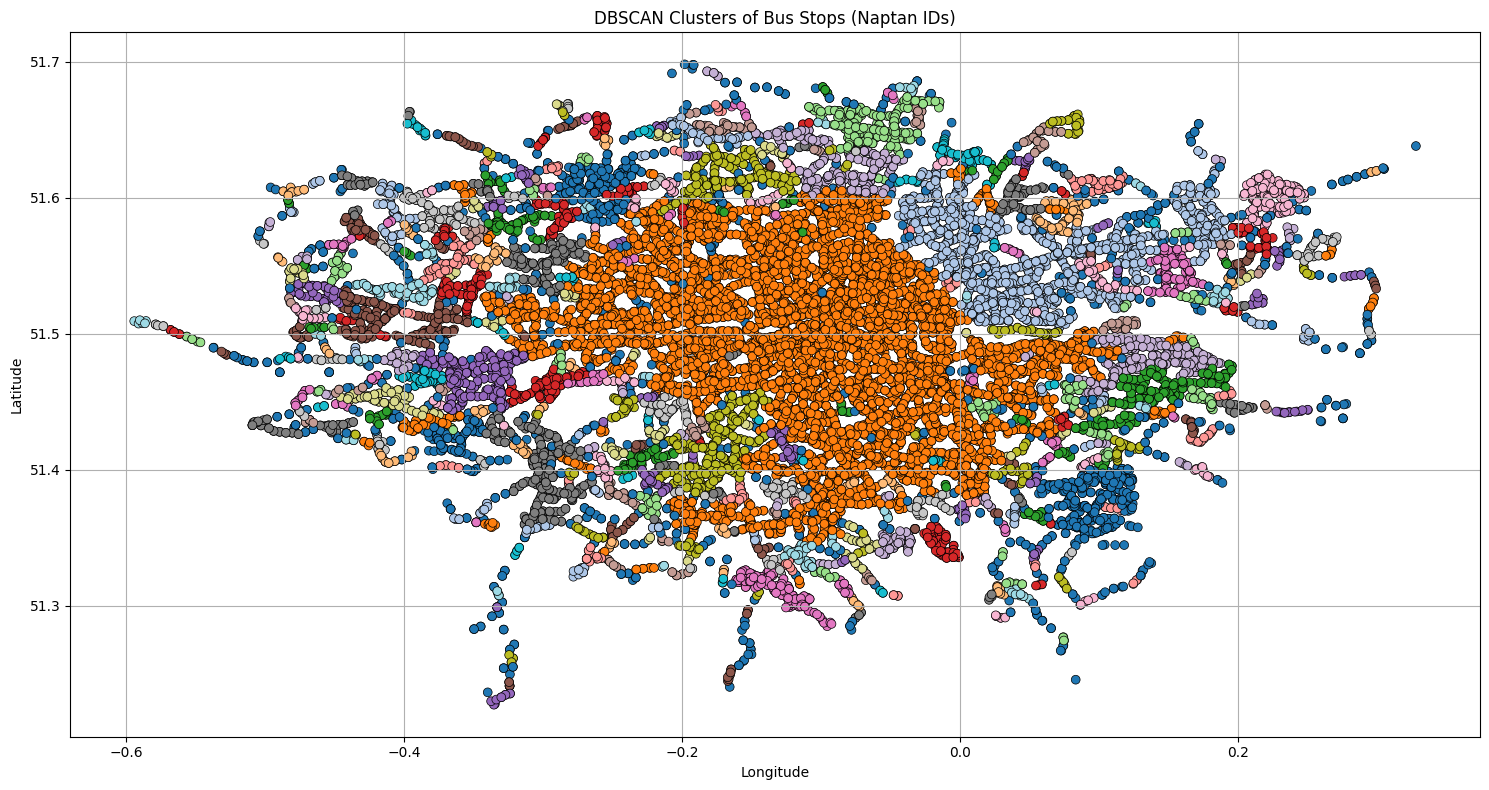

In [104]:
# df_plot = stations_mapping_raw[stations_mapping_raw['cluster'] != -1]
df_plot = stations_mapping_raw
# df_plot = stations_mapping_raw[stations_mapping_raw['cluster'].isin([-1, 0,1,2,3,4,5])]

plt.figure(figsize=(15, 8))
sns.scatterplot(
    data=df_plot,
    x='longitud',
    y='latitude',
    hue='cluster',
    palette='tab20',  
    s=40,
    edgecolor='black'
)
plt.title("DBSCAN Clusters of Bus Stops (Naptan IDs)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend().remove()
plt.grid(True)
plt.tight_layout()
plt.show()

In [105]:
# Kmeans Test
coords_KMeans = stations_mapping_raw[['latitude', 'longitud']]

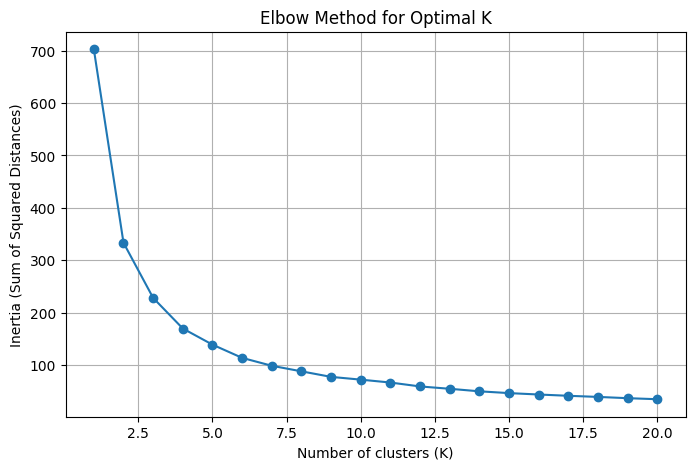

In [106]:
inertia = []
K_range = range(1, 21)  # Try K=1 to K=20

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(coords_KMeans)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.title('Elbow Method for Optimal K')
plt.grid(True)
plt.show()

In [107]:
optimal_k = 150
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
stations_mapping_raw['cluster_KMeans'] = kmeans.fit_predict(coords_KMeans)

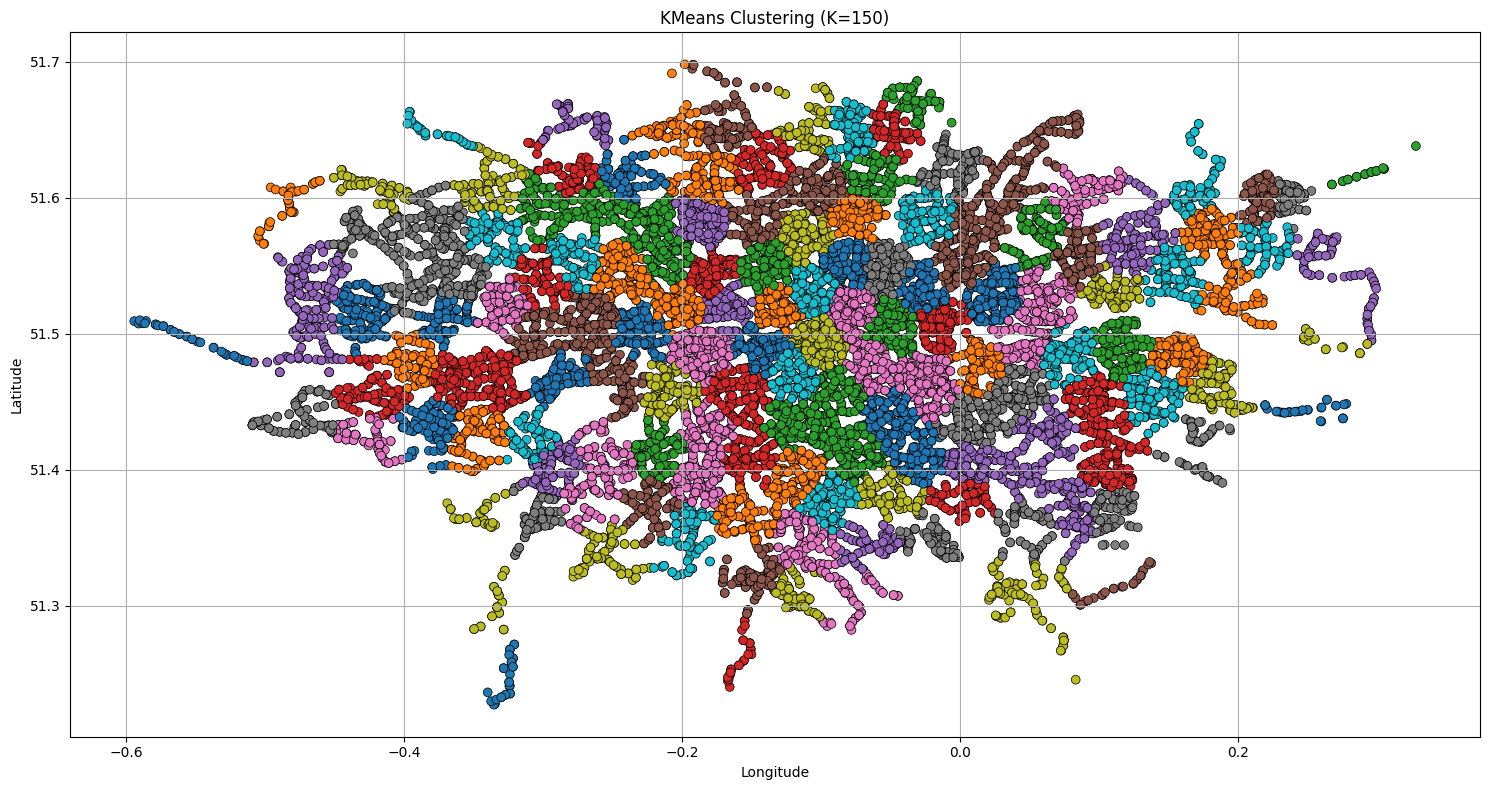

In [108]:
plt.figure(figsize=(15, 8))
sns.scatterplot(
    data=stations_mapping_raw,
    x='longitud',
    y='latitude',
    hue='cluster_KMeans',
    palette='tab10',
    s=40,
    edgecolor='black'
)
plt.title(f"KMeans Clustering (K={optimal_k})")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend().remove()
plt.grid(True)
plt.tight_layout()
plt.show()

In [109]:
# Aglomerative Clustering

model = AgglomerativeClustering(
    distance_threshold=0.005,   # ~0.01 degrees = ~1km
    n_clusters=None,           # required when using distance threshold
    linkage='ward'
)

stations_mapping_raw['clusterAgglomerative'] = model.fit_predict(coords_rad)

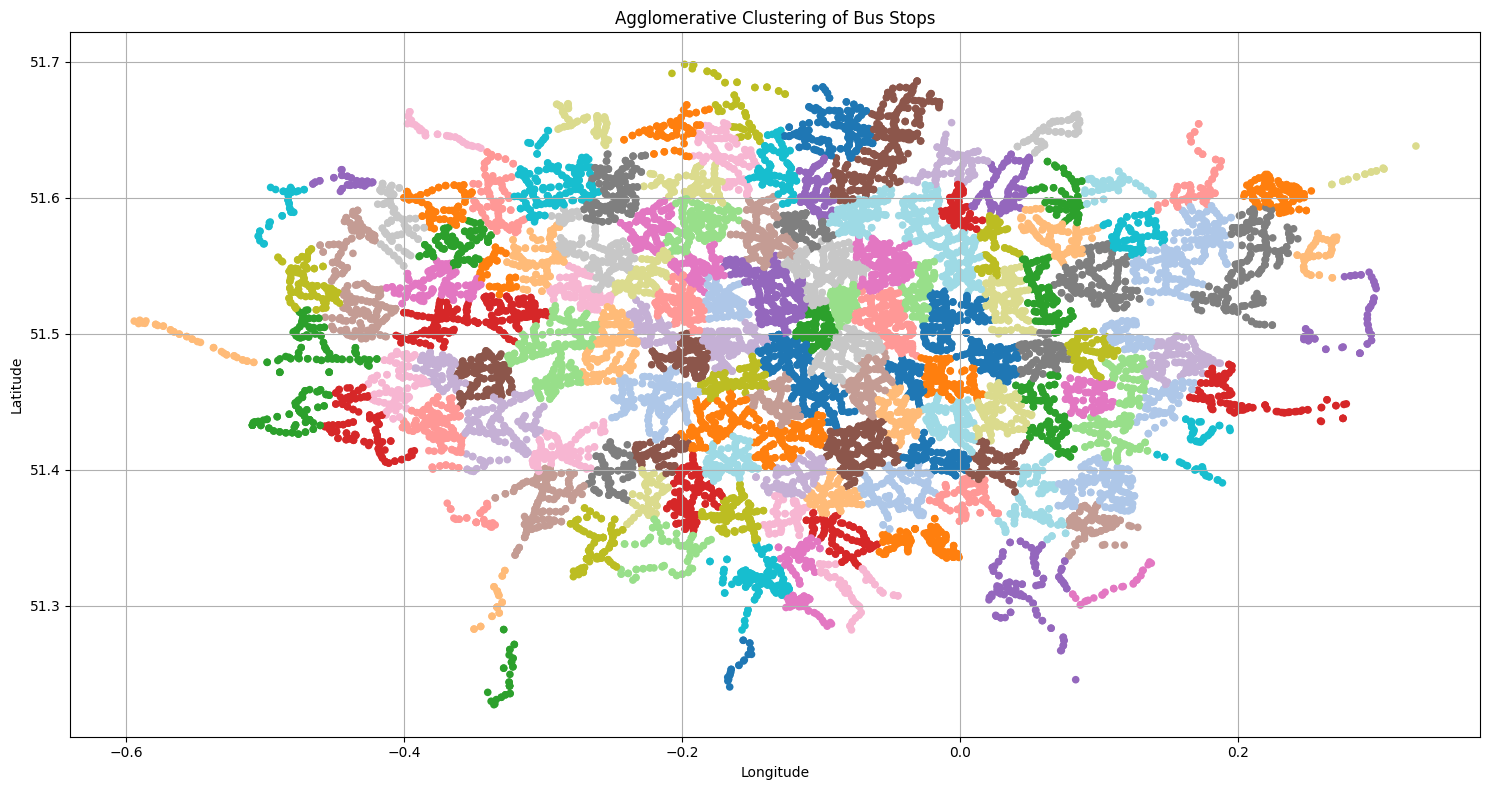

In [110]:
plt.figure(figsize=(15, 8))
sns.scatterplot(
    data=stations_mapping_raw,
    x='longitud',
    y='latitude',
    hue='clusterAgglomerative',
    palette='tab20',
    s=30,
    linewidth=0,
)
plt.title("Agglomerative Clustering of Bus Stops")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend().remove()
plt.grid(True)
plt.tight_layout()
plt.show()

In [111]:
coords_rad_dist = np.radians(stations_mapping_raw[['latitude', 'longitud']].values)

radii = []

for cluster_id in np.unique(stations_mapping_raw['clusterAgglomerative']):
    cluster_points = coords_rad_dist[stations_mapping_raw['clusterAgglomerative'] == cluster_id]
    if len(cluster_points) <= 1:
        continue  # skip noise or single-point clusters

    # Compute cluster centroid in radians
    centroid = cluster_points.mean(axis=0).reshape(1, -1)

    # Haversine distances to centroid (in radians)
    distances = haversine_distances(cluster_points, centroid)

    # Convert to km
    distances_km = distances * 6371.0088

    # Take average distance (i.e. avg cluster radius)
    avg_radius = distances_km.mean()
    radii.append(avg_radius)

print(f"Average cluster radius: {statistics.mean(radii):.2f} km")
print(f"Max cluster radius: {max(radii):.2f} km")
print(f"Min cluster radius: {min(radii):.2f} km")

Average cluster radius: 1.30 km
Max cluster radius: 2.42 km
Min cluster radius: 0.82 km


In [112]:
# PROXIMITY OF NEW DATA POINTS NOT CAPTURED YET -- > SHOULD BE VERY FEW DATA POINTS

# Your existing clustered data
clustered_coords = np.radians(stations_mapping_raw[['latitude', 'longitud']].values)
cluster_labels = stations_mapping_raw['clusterAgglomerative'].values

# New point (also in radians)
new_point = np.radians([[51.50011,-0.44156]])

# Compute distances to all points
distances = haversine_distances(clustered_coords, new_point) * 6371.0088  # km

# Find the closest point
closest_index = np.argmin(distances)
closest_cluster = cluster_labels[closest_index]

print(f"Closest cluster: {closest_cluster}")

Closest cluster: 91


In [113]:
print(len(stations_mapping_raw['cluster'].unique()))
print(len(stations_mapping_raw['cluster_KMeans'].unique()))
print(len(stations_mapping_raw['clusterAgglomerative'].unique()))

497
150
147


In [114]:
stations_mapping_raw.head()

,naptanId,commonName,latitude,longitud,cluster,cluster_KMeans,clusterAgglomerative
0,490007996K,Heathfield Park Drive,51.57806,0.11424,0,134,98
1,490012142N,Sidcup Road,51.45057,0.03113,1,117,97
2,490013340E,The Dysart,51.44637,-0.29969,2,10,9
3,490007969Z,Avondale Road,51.46700,0.12082,3,129,65
4,490004065BA,Blackheath / Royal Standard,51.47771,0.02041,1,1,80


In [115]:
stations_mapping_to_BQ = stations_mapping_raw[['naptanId', 'commonName', 'latitude', 'longitud', 'clusterAgglomerative']]

In [119]:
# Send clusterized table to BQ
cluster_table_name = 'stopspoint_coordinates_aggloclusters_enriched'

schema = [
    bigquery.SchemaField("naptanId", "STRING"),
    bigquery.SchemaField("commonName", "STRING"),
    bigquery.SchemaField("latitude", "FLOAT"),
    bigquery.SchemaField("longitud", "FLOAT"),
    bigquery.SchemaField("clusterAgglomerative", "INTEGER"),  # if you're including clusters
    # Add more fields if needed
]

job_config = bigquery.LoadJobConfig(
    schema=schema,
    write_disposition="WRITE_TRUNCATE"
)

job = BQ_client.load_table_from_dataframe(
    dataframe=stations_mapping_to_BQ,            
    destination= f'{PROJECT_ID}.{DATA_SET}.{cluster_table_name}',                
    job_config=job_config

)

print(f"✅ Table {cluster_table_name} successfully overwritten with {len(stations_mapping_to_BQ)} rows.")

/Users/delgadonoriega/Desktop/gcp-data-eng-bootcamp/.cloud_run/lib/python3.12/site-packages/google/cloud/bigquery/_pandas_helpers.py:489: FutureWarning: Loading pandas DataFrame into BigQuery will require pandas-gbq package version 0.26.1 or greater in the future. Tried to import pandas-gbq and got: No module named 'pandas_gbq'
  warnings.warn(


✅ Table stopspoint_coordinates_aggloclusters_enriched successfully overwritten with 19461 rows.
